<a href="https://colab.research.google.com/github/ant358/ColabGitHub/blob/main/notebooks/How_you_can_use_Python_to_discover_the_top_ten_momentum_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How you can easily use Python to find the top ten momentum stocks     
A step by step guide to a process I use each month to choose my next potential investment. This of course is not investment advice and there is no garauntee you will make money, but it is an easy way to get some good price information and analysis was born out of my own frustration that I could not -in a world of infromation - find a simple league table of the fastest growing shares. This code is designed to load and run online in a Google Collabortory notebook, so you can get away with not knowing or caring how to run Python.  And if you have not used Python to analyse data before - welcome to the new World! Its possible to to all this online without having a high powered computer or spending hours downloading and configuring software.

## First find out what stocks available to trade      
Download the available shares data. 
I use Freetrade as a broker, at the time of writing, the Freetrade available stock list was on this [page](   
https://freetrade.io/stock-list#stock-list-table). And the data itself stored in a [spreadsheet](  
https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257)

Of course these links may change, therefore edit if the link below if it broken. Or if you use a different broker find there listings. The goal here is to have a list of stocks symbols to evaluate! 

In [ ]:
# import the Python packages required
import pandas as pd
import numpy as np
import io
import requests
import pprint
import matplotlib.pyplot as plt

The stock listings link above is for a multitab Google docs spreadsheet we only need one tab so, there is a bit of work to adjust the link and get only the sheet we need<sup>1</sup>.

In [ ]:
# the freetrade file link
link = "https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257"
# split the link after /edit - keep just the first part
url_start = link.split('/edit')[0]
# add the sheet name
sheet_name = 'Freetrade Universe'
url_end = f"/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# build the new link
url = url_start + url_end
url

'https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/gviz/tq?tqx=out:csv&sheet=Freetrade Universe'

The Python [Requests](https://docs.python-requests.org/en/latest/) package makes it easy to grab data from websites, so we will use that to get the spreadsheet url, and [StringIO](https://docs.python.org/3/library/io.html) to knock the data into a readable format.  

In [ ]:
# use python requests package to get the file
file = requests.get(url).content
# use python io to read the file into a pandas dataframe 
df = pd.read_csv(io.StringIO(file.decode('utf-8')))
# view the first 5 lines
df.head()

,Title,Long_Title,Subtitle,Currency,ISA_eligible,SIPP_eligible,ISIN,MIC,Symbol,Fractional_Enabled,PLUS_only,for_Ireland_investors,for_Netherlands_investors,KIID_URL,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,Dingdong,Dingdong Ltd,Grocery delivery,usd,False,False,US25445D1019,XNYS,DDL,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AvidXchange,AvidXchange Holdings Inc,Payment solutions,usd,True,True,US05368X1028,XNAS,AVDX,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Theseus Pharma,Theseus Pharmaceuticals Inc,Biopharmaceuticals,usd,True,True,US88369M1018,XNAS,THRX,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Membership,Membership Collective Group Inc,Soho House,usd,True,True,US5860011098,XNYS,MCG,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F45,F45 Training Holdings Inc,Gyms,usd,True,True,US30322L1017,XNYS,FXLV,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Next filter the dataframe of stocks for your account circumstances  
When you look at the columns in the data, there are some boolean (True/False) columns to filter the stocks by. e.g. my investments are held in a UK ISA for tax efficiency, I am not a Plus subscriber, and I like being able to buy Fractional shares. So I need to choose only the True rows to filter the number of shares as follows.

In [ ]:
# how many shares are there to start with?
print('Number of shares available: ',len(df))
# choose only the ISA eligible ones
df = df[df['ISA_eligible']==True]
# whats left?
print('Number of shares available: ',len(df))

Number of shares:  5560
Number of shares:  5129


In [ ]:
# deselect the Plus account only shares
df = df[df['PLUS_only']==False]
print('Number of shares available: ',len(df))

Number of shares:  4025


In [ ]:
# make sure they can be traded fractionally
df = df[df['Fractional_Enabled']==True]
print('Number of available: ',len(df))

Number of shares:  3388


## Now clean up the speadsheet   
Drop the other columns and keep a few useful ones for reference information.      
1) [ISIN](https://en.wikipedia.org/wiki/International_Securities_Identification_Number ) - this is a unique identifier for all stocks Worldwide   
2) [MIC](https://www.iso20022.org/market-identifier-codes) - this is an identifier for the exchange the stocks are traded on  
3) Subtitle - looks like the market sector the stock is in.  
4) Symbol is the market ticker  
5) The title, long title and account currency  

In [ ]:
# Copy to a new dataframe and keep only the useful columns
tradeable = df[['Title', 'Long_Title', 'Subtitle', 'Currency', 'ISIN', 'MIC', 'Symbol']].copy()

## Time to get the share price data from the internet?

There are many sites providing comprehensive share price data  we can use Python to automatically grab this data from the internet?  
First stop Yahoo Finance<sup>4</sup> and there is a python module to work with that data called yfinance<sup>5</sup> 

In [ ]:
# install yfinance or import it if this is not the first time running this notebook
try: 
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

     |████████████████████████████████| 6.3 MB 5.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=0ca76ab82f229afadce478aed727f4d0fa3fd75f50108132dc497ad6dd2df8fb
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Have we got unique tickers for all the instruments?

In [ ]:
tradeable['Symbol dups'] = tradeable.duplicated(subset='Symbol', keep=False)
tradeable[tradeable['Symbol dups']==True]

,Title,Long_Title,Subtitle,Currency,ISIN,MIC,Symbol,Symbol dups
1133,Vereit,Vereit Inc (REIT),Store REIT,usd,US92339V3087,XNYS,VER,True
1787,Vereit,Vereit Inc (REIT),Store REIT,usd,US92339V1008,XNYS,VER,True
2866,Arthur J. Gallagher,Arthur J. Gallagher & Co,Insurance,usd,US3635761097,XNYS,AJG,True
4403,Arthur J. Gallagher,Arthur J. Gallagher & Co.,Insurance,usd,AJG,XNYS,AJG,True


It looks like they are the same company, a manual check on Yahoo finance does not show two different share prices so I think we can just use the tickers to look up the historical data in yahoo finance.

In [ ]:
# drop the duplicates
tradeable.drop_duplicates(subset='Symbol', keep='first', inplace=True)

## Time to collect the historical share price data

In [ ]:
tradeable.Symbol.nunique()

3386

In [ ]:
# data_close = pd.DataFrame()

In [ ]:
# for ticker in tradeable.Symbol.to_list():
#     t = yf.Ticker(ticker)
#     share_data = t.history(period="3mo", auto_adjust=True)
#     share_data[ticker] = share_data[['Close']]\
#                                .pct_change(1)
#     data_close = data_close.append(share_data[ticker])

In [ ]:
# data_close

In [ ]:
%timeit
# auto_adjust works the opposite way round to expected,  setting to false adjusts the price for stock splits correctly
share_data = yf.download(tradeable.Symbol.to_list(),
                         period="3mo", 
                         interval="1d", 
                         auto_adjust=True, 
                         back_adjust=True,
                         prepost=True)

[*********************100%***********************]  3386 of 3386 completed

13 Failed downloads:
- LGF.B: No data found for this date range, symbol may be delisted
- IPOC: No data found, symbol may be delisted
- PBR.A: No data found, symbol may be delisted
- LGF.A: No data found, symbol may be delisted
- BF.A: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- CWEN.A: No data found, symbol may be delisted
- HEI.A: No data found, symbol may be delisted
- OIBR.C: No data found, symbol may be delisted
- JW.A: No data found, symbol may be delisted
- BF.B: None
- FTIV: No data found, symbol may be delisted
- LEN.B: None


In [ ]:
data_close = share_data['Close']
data_returns = data_close.pct_change(1)
data_returns.head()

,A,AA,AAC,AAL,AAN,AAP,AAPL,AAQC,AAT,ABB,ABBV,ABC,ABCL,ABEO,ABEV,ABMD,ABNB,ABOS,ABR,ABSI,ABST,ABT,ABTX,ABUS,AC,ACAD,ACAH,ACB,ACBI,ACC,ACCD,ACCO,ACEL,ACET,ACEV,ACGL,ACH,ACHC,ACHR,ACI,...,YI,YMAB,YMM,YNDX,YORW,YOU,YTRA,YUM,YUMC,Z,ZBH,ZBRA,ZD,ZEAL,ZEN,ZENV,ZETA,ZEV,ZGNX,ZI,ZIM,ZION,ZIOP,ZIP,ZIXI,ZM,ZNGA,ZNTE,ZNTL,ZOM,ZS,ZTS,ZUO,ZVIA,ZVO,ZWRK,ZWS,ZY,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-16,-0.000201,-0.046034,-0.001024,-0.032747,0.006791,-0.016249,-0.014076,0.002062,-0.005376,-0.010665,0.002731,-0.002474,0.024198,-0.051852,-0.002941,0.025114,-0.023200,0.032370,0.000000,NaN,-0.008778,0.007286,-0.022125,0.003774,-0.014841,0.014680,0.0,-0.040872,-0.020623,0.005374,-0.025837,-0.010976,-0.007902,-0.022556,-0.002026,0.002633,0.046929,-0.019871,0.000000,0.004038,...,-0.021592,0.015720,0.002331,-0.000718,0.034130,0.057500,-0.027778,-0.009744,-0.009188,-0.006866,0.001959,-0.008209,0.000793,0.047619,0.003459,NaN,-0.033386,-0.016176,-0.049776,0.000000,-0.053277,-0.040062,0.008584,-0.004876,0.000000,0.014461,0.003891,0.000998,0.002116,-0.001645,0.008436,-0.002797,-0.005556,NaN,-0.057471,-0.002066,-0.022013,0.027436,0.003652,-0.027659
2021-07-19,-0.009065,-0.040364,0.001025,-0.041435,-0.028399,-0.000874,-0.026914,0.003086,-0.054324,-0.023546,-0.017702,-0.002480,-0.030124,-0.039062,-0.053097,-0.010567,-0.018092,0.069989,-0.024266,NaN,0.003690,0.010893,-0.029050,0.018797,-0.032727,-0.012340,0.0,0.000000,-0.026012,-0.033261,-0.004348,-0.033292,-0.027434,0.028205,0.002030,-0.033088,-0.008570,-0.014529,0.000000,0.033685,...,-0.001379,-0.016109,-0.052326,-0.018524,-0.014925,-0.073286,-0.033766,-0.020716,-0.014219,0.005953,-0.021056,-0.022032,-0.013254,-0.005387,-0.009754,NaN,-0.006579,-0.020927,-0.057681,0.012261,0.004756,-0.038306,0.000000,-0.060841,0.014992,-0.021466,0.004845,-0.002991,0.017948,-0.008237,0.008365,-0.009265,-0.009932,NaN,0.000000,-0.001035,-0.024518,0.072879,0.010076,0.002188
2021-07-20,0.011655,0.105313,-0.002047,0.083817,0.042748,0.022171,0.025974,-0.007179,0.048299,0.020337,0.005458,0.034547,-0.004872,0.024390,-0.003115,0.028511,0.031923,-0.031397,0.027183,NaN,0.008088,-0.000505,0.012658,0.003690,0.006982,0.045239,0.0,0.035511,0.016108,0.035429,0.056550,0.029337,0.033667,0.047381,-0.001013,0.029060,-0.011968,0.051603,-0.001010,0.004864,...,0.006906,0.051043,0.003068,0.003219,0.019206,0.071684,0.069892,0.023887,0.013484,0.030734,0.036359,0.025172,0.025695,0.000000,0.026735,NaN,-0.004967,0.050382,0.051218,0.042494,-0.013673,0.052411,0.051064,0.026087,0.050222,0.004545,0.009643,0.001000,0.023439,0.078073,0.027353,0.012805,0.032602,NaN,0.056911,0.000000,0.038319,0.027742,0.019119,0.017467
2021-07-21,-0.002344,0.061230,0.001026,0.040856,0.015417,-0.003948,-0.005132,0.000000,0.020174,0.020501,0.008100,0.014851,0.017136,0.071429,0.018750,-0.002287,0.023220,-0.072393,0.005068,NaN,0.008023,0.002106,0.022727,0.080882,0.027200,-0.021847,0.0,0.031550,0.011264,-0.006725,0.033065,0.001239,0.024648,-0.045238,-0.001014,0.015571,0.029610,0.010597,-0.002022,0.010649,...,0.048011,0.070556,0.012844,0.017938,-0.007328,0.003333,-0.025126,0.005251,0.008509,0.033985,0.025316,0.027133,0.017294,0.003047,0.012623,NaN,0.006656,0.031977,0.043969,-0.003048,0.065849,0.028685,-0.028340,0.031780,0.012658,-0.007982,-0.002865,0.000999,0.025334,0.013867,0.008511,-0.010344,0.054645,NaN,0.000000,0.000000,0.051190,-0.039606,0.004894,0.032189


In [ ]:
data_cum_returns = (1 + data_returns).cumprod() -1

In [ ]:
# take the last row
latest = data_cum_returns.tail(1).T.mul(100)
# label the column
latest.columns = ['% change']
# show the top ten
topten = round(latest.sort_values(by='% change', ascending=False)[:30], 2)
topten

,% change
UPST,252.98
FULC,187.89
AFRM,164.00
METC,158.13
KDMN,148.69
AMR,144.14
CCXI,134.16
SD,132.89
BTBT,127.25
TRIL,126.22


In [ ]:
print(topten.index)

Index(['UPST', 'FULC', 'AFRM', 'METC', 'KDMN', 'AMR', 'CCXI', 'SD', 'BTBT',
       'TRIL', 'TASK', 'LEU', 'GSKY', 'AMTX', 'LC', 'CAR', 'SITM', 'RSI',
       'MARA', 'GOSS', 'ENOB', 'DOCN', 'SLI', 'XENE', 'AUPH', 'TA', 'ORMP',
       'ASPS', 'LAC', 'AVIR'],
      dtype='object')


In [ ]:
# get further information
topten_info = {}
for i in topten.index:
    topten_info[i] = yf.Ticker(i).info

In [ ]:
info_df = pd.DataFrame.from_dict(topten_info,orient='index')

In [ ]:
info_df['Growth'] = topten

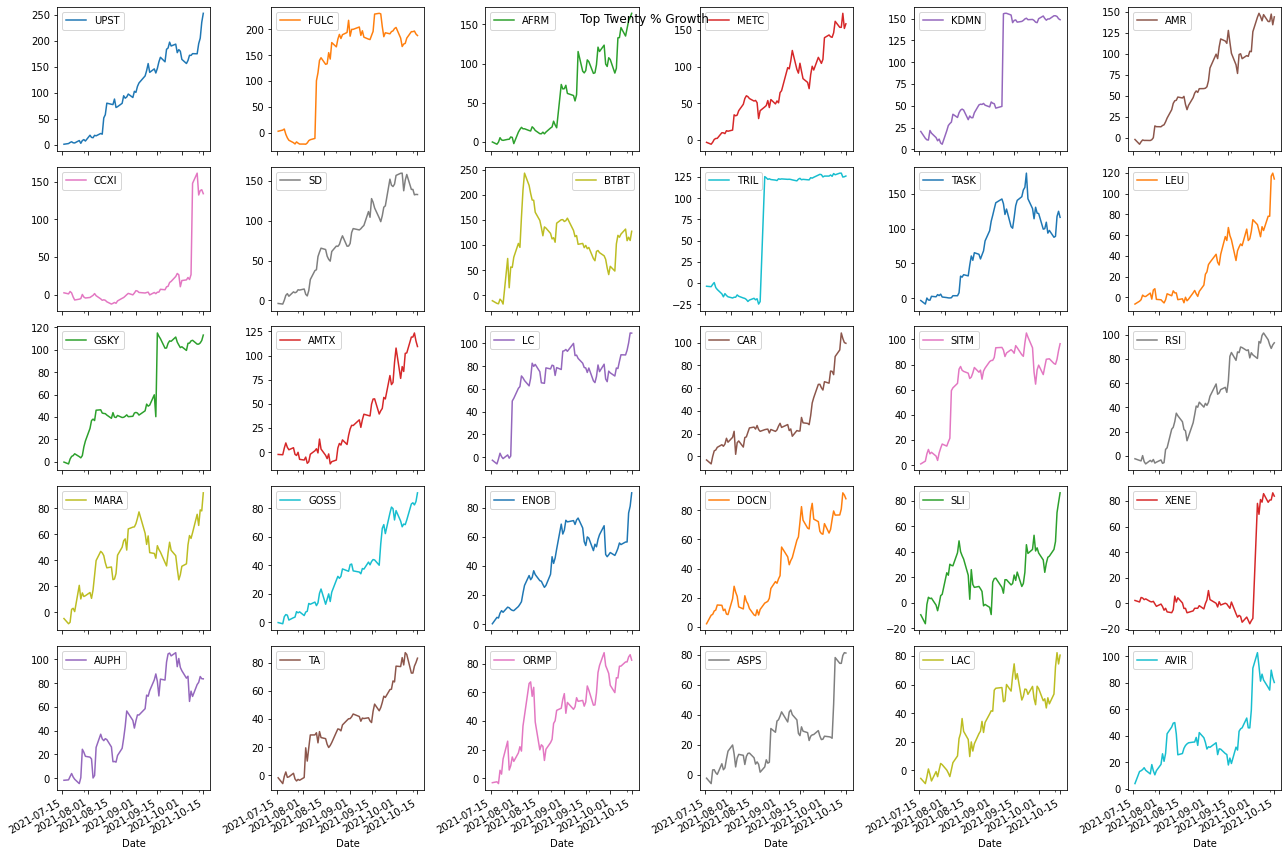

In [ ]:
data_cum_returns[list(topten.index)].mul(100).plot(subplots=True, 
                                          layout=(5, 6), 
                                          figsize=(18,12),
                                          title='Top Twenty % Growth')
plt.tight_layout()
plt.show()

In [ ]:
# Add symbols to the list that you don't want info for
info_df.drop(['TRIL', 'KDMN', 'FULC', 'CCXI' ], axis=0, inplace=True)

In [ ]:
info_df.sort_values(by=['Growth'], ascending=False)

,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,maxAge,address1,industry,address2,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,recommendationKey,grossProfits,freeCashflow,targetMedianPrice,currentPrice,earningsGrowth,currentRatio,returnOnAssets,numberOfAnalystOpinions,targetMeanPrice,debtToEquity,returnOnEquity,targetHighPrice,totalCash,totalDebt,totalRevenue,totalCashPerShare,financialCurrency,...,trailingAnnualDividendRate,open,averageVolume10days,expireDate,algorithm,dividendRate,exDividendDate,circulatingSupply,startDate,regularMarketDayLow,currency,regularMarketVolume,lastMarket,maxSupply,openInterest,marketCap,volumeAllCurrencies,strikePrice,averageVolume,dayLow,ask,askSize,volume,fiftyTwoWeekHigh,fromCurrency,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,logo_url,lastDividendDate,impliedSharesOutstanding,toCurrency,trailingPE,fax,Growth
UPST,94403,Financial Services,554.0,"Upstart Holdings, Inc. operates a cloud- based...",San Mateo,650 204 1000,CA,United States,[],http://www.upstart.com,1,2950 South Delaware Street,Credit Services,Suite 300,0.11858,0.04925,0.84436,145311008,0.820,0.10988,3.516600e+07,160.00,buy,2.038610e+08,NaN,230.0,398.0000,0.087,8.135,NaN,7.0,234.00,18.875,NaN,300.0,257016992,60512000,2.965680e+08,3.342,USD,...,None,385.0000,4005500,None,None,None,NaN,None,None,380.6000,USD,3032545,None,None,None,30607872000,None,None,4928646,380.6000,395.37,1400,3032545,401.440,None,None,22.61,394.89,False,None,900,401.4400,398.0000,https://logo.clearbit.com/upstart.com,NaN,NaN,NaN,NaN,NaN,252.98
AFRM,94108,Technology,1641.0,"Affirm Holdings, Inc. operates a platform for ...",San Francisco,415 984 0490,CA,United States,[],http://www.affirm.com,1,650 California Street,Information Technology Services,NaN,-0.32002,-0.49505,0.49562,-193130000,0.707,-0.42236,-2.785670e+08,65.00,buy,4.314190e+08,-1.661426e+08,110.0,152.1100,NaN,18.230,-0.07330,13.0,117.69,76.799,-0.28555,160.0,1466557952,1982306048,8.704640e+08,5.394,USD,...,None,148.6600,28635912,None,None,None,NaN,None,None,145.5400,USD,5373422,None,None,None,39809622016,None,None,11359003,145.5400,152.12,1200,5373422,153.490,None,None,46.50,151.87,False,None,1200,153.2000,152.1100,https://logo.clearbit.com/affirm.com,NaN,271875008.0,NaN,NaN,NaN,164.00
METC,40507,Basic Materials,349.0,"Ramaco Resources, Inc. produces and sells meta...",Lexington,859 244 7455,KY,United States,[],http://www.ramacoresources.com,1,250 West Main Street,Coking Coal,Suite 1800,0.07356,0.02172,0.17478,39401000,1.091,-0.03650,1.545700e+07,5.25,buy,2.341200e+07,2.050962e+07,11.0,15.0500,2.750,1.565,-0.01960,5.0,10.25,7.254,0.02522,13.0,19394000,13451000,2.101160e+08,0.440,USD,...,None,15.0700,523037,None,None,None,NaN,None,None,14.8500,USD,68836,None,None,None,663846464,None,None,332893,14.8500,15.20,1400,68836,16.750,None,None,2.67,15.07,False,None,800,15.2900,15.0500,https://logo.clearbit.com/ramacoresources.com,NaN,NaN,NaN,152.020200,NaN,158.13
AMR,37620,Basic Materials,3300.0,"Alpha Metallurgical Resources, Inc. operates a...",Bristol,423 573 0300,TN,United States,[],http://www.alphametresources.com,1,340 Martin Luther King Jr. Boulevard,Coking Coal,NaN,0.08244,-0.15317,0.09386,24847000,0.117,-0.00756,1.187970e+08,38.00,hold,1.351760e+08,4.902625e+06,38.0,61.6100,NaN,1.715,-0.00368,1.0,38.00,357.089,-0.61153,38.0,72337000,579667008,1.440971e+09,3.931,USD,...,None,59.2300,220812,None,None,None,1.498781e+09,None,None,58.3515,USD,46061,None,None,None,1133642496,None,None,287920,58.3515,61.60,1200,46061,66.040,None,None,11.13,60.86,False,None,900,62.1200,61.6100,https://logo.clearbit.com/alphametresources.com,NaN,NaN,NaN,NaN,NaN,144.14
SD,73102-6406,Energy,114.0,"SandRidge Energy, Inc. engages in the acquisit...",Oklahoma City,405 429 5500,OK,United States,[],http://www.sandridgeenergy.com,1,1 E. Sheridan Avenue,Oil & Gas 

In [ ]:
info_df.to_csv('growth_shares_info.csv')

References  
1. https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550    
2. https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url   
3. https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e    
4.https://pypi.org/project/yfinance/  
